## I. Summary

### **TL;DR**
ACME initiated the Career 2030 training initiative, focused on boosting employee promotions and retention. A total of 6,000 ACME employees participated in this program, with a split between those who received training and those who did not, representing 10% of the company's total employee base. The company seeks to analyze the impact of the program on its workforce.
Our objectives are twofold: (1) to assess the effectiveness of the training sessions, and (2) to formulate strategic recommendations. First, we want to determine the efficiency of the training sessions, eliminating any confounding variables to ensure that observed outcomes are truly attributable to the training. If we establish that the training is effective, we will then explore strategic approaches to potentially expand its implementation.




## II. Business Understanding

### **Background**

ACME Manufacturing, a company with over 60,000 employees, has launched the Career 2030 training program aimed at fostering the career development of its workforce. Despite its ongoing nature, the initial data from a randomly selected cohort of employees who participated in the training a year earlier has recently become available. ACME's Chief People Officer prioritizes data-informed decision-making and seeks insights into the program's impact on employee promotion and retention.

### **Problem**

Your analytics consulting group, specializing in causal inference, is one of six firms being considered by ACME to continuously monitor the effects of various employee programs, including Career 2030. As a proof of concept, the client desires a demonstration of your analysis approach, insights derived from the data, and recommendations for program optimization. The dataset provided by the client originates from a randomized controlled trial, where 5% of employees were randomly selected for training while another 5% were not. However, external factors such as interventions by managers and individual motivations may have influenced participation. There were also anecdotal evidence that some managers intervened for direct reports to be part of the program. It is also a fact that some motivated employees may be more interested in the training program as well as upward mobility in their careers.

### **Data**
The dataset comprises 6,000 employee records with the following attributes:

- empid: Employee ID
- promoted: Whether the employee was promoted within a year of training
- training: Participation in the Career 2030 program
- manager: Employee managerial status
- raise: Merit increase in the last review cycle
- salary: Employee's salary bracket
- children: Number of children
- mstatus: Marital status
- age: Age at promotion
- sex: Gender
- edu: Years of education at promotion
- vacation: Vacation days taken in the year prior to promotion
- weight: Weight at the last physical examination
- height: Height at the last physical examination
- hrfriend: Friend within the Human Resources department
- cxofriend: C-level friend within the organization
- insurance: Type of insurance coverage
- flexspend: Participation in the Flexible Spending Account program
- retcont: Participation in the 401k retirement saving program
- race: Race
- disthome: Distance from training facility to employee's home
- testscore: Score in a standard test during the recruitment process

## III. Analytics

### Step 1. Settings

In [1]:
install.packages("ggplot2")
install.packages("tableone")
install.packages("Matching")
install.packages('fastDummies')
install.packages("dagitty")
install.packages('survey')

library(ggplot2)
library(tableone)
library(Matching)
library(fastDummies)
library(survey)
library(dagitty)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘Rcpp’, ‘RcppArmadillo’, ‘proxy’, ‘gdata’, ‘survey’, ‘e1071’, ‘zoo’, ‘gmodels’, ‘labelled’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘V8’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: MASS

## 
##  Matching (Version 4.10-14, Build Date: 2023-09-13)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Op

In [ ]:
# Read the data into R
path <- '/content/sample_data/TrainingPromoData.csv'
import_data <- read.csv(path)

# Show the first 3 rows of the data
head(import_data, 3)

,empid,promoted,training,manager,raise,salary,children,mstatus,age,sex,⋯,weight,height,hrfriend,cxofriend,insurance,flexspend,retcont,race,disthome,testscore
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,5,No,No,No,Yes,Under $20k,2,divorced,49,Male,⋯,142.84,56.24,Yes,No,Medicaid,Yes,No,white,20,59.0
2,9,No,Yes,No,No,$40-$80k,0,divorced,32,Female,⋯,199.62,53.72,No,No,Covered,Yes,No,white,2,64.5
3,10,Yes,No,No,Yes,$20-$40k,2,married,53,Female,⋯,117.66,61.75,Yes,Yes,Covered & Medicaid,No,No,white,28,57.0


### Step 2. Exploratory Data Analysis


*   Approximately 38.2% (N = 2,291) participated in the Career 2030 training program, while 61.8% (N = 3,709) did not participate.
*   Managers represent 14.4% (N = 864) of the workforce, with non-managers making up 85.6% (N = 5,136).
*   Around 53.6% (N = 3,216) of the employees have a friend in HR, while 55.05% (N = 3,303) have a friend at the C-level.
*   For benefits participation, 66.43% (N = 3,986) are enrolled in the flexible spending account.
*   Around 87.92% (N = 5,275) contribute to a retirement savings plan.






In [ ]:
# copy dataset
data <- import_data

In [ ]:
data$promoted <- ifelse(data$promoted == "Yes", 1, 0)
data$training <- ifelse(data$training == "Yes", 1, 0)

#### Categorical Variables

In [ ]:
cat_var <- c("promoted", "training", "manager", "raise", "salary", "mstatus", "sex",
             "hrfriend", "cxofriend", "insurance", "flexspend", "retcont", "race")

num_var <- c("children", "age", "edu", "vacation", "weight", "height", "disthome", "testscore")

# Calculate the relative proportion of values in each categorical variable
calculate_categorical_stats <- function(data, cat_var) {
  categorical_vars <- data[, cat_var]
  results <- list()
  # Loop over each categorical variable
  for (col in colnames(categorical_vars)) {
    counts <- table(categorical_vars[[col]])
    percentages <- prop.table(counts) * 100
    stats <- data.frame(Value = names(counts), Count = as.vector(counts), Percentage = round(as.vector(percentages),2))
    stats <- stats[order(-stats$Count), ]
    results[[col]] <- stats
  }
  all_results <- do.call(rbind, results)
  return(all_results)}

stats <- calculate_categorical_stats(data, cat_var)
print(stats)

                          Value Count Percentage
promoted.2                    1  3904      65.07
promoted.1                    0  2096      34.93
training.1                    0  3709      61.82
training.2                    1  2291      38.18
manager.1                    No  5136      85.60
manager.2                   Yes   864      14.40
raise.1                      No  3796      63.27
raise.2                     Yes  2204      36.73
salary.4             Under $20k  3370      56.17
salary.2               $20-$40k  1214      20.23
salary.3               $40-$80k   943      15.72
salary.1                 > $80k   473       7.88
mstatus.3                single  3345      55.75
mstatus.1              divorced  1377      22.95
mstatus.2               married  1278      21.30
sex.2                      Male  3338      55.63
sex.1                    Female  2662      44.37
hrfriend.2                  Yes  3216      53.60
hrfriend.1                   No  2784      46.40
cxofriend.2         

#### Numeric Variables

    children          age             edu           vacation    
 Min.   :0.000   Min.   :18.00   Min.   :-1.00   Min.   : 6.00  
 1st Qu.:1.000   1st Qu.:35.00   1st Qu.:10.00   1st Qu.: 8.00  
 Median :1.000   Median :45.00   Median :12.00   Median :10.00  
 Mean   :1.383   Mean   :42.99   Mean   :11.62   Mean   :10.38  
 3rd Qu.:2.000   3rd Qu.:52.00   3rd Qu.:13.00   3rd Qu.:12.00  
 Max.   :5.000   Max.   :71.00   Max.   :30.00   Max.   :18.00  
     weight           height         disthome       testscore     
 Min.   : 44.72   Min.   :52.96   Min.   : 1.00   Min.   : 17.00  
 1st Qu.:131.92   1st Qu.:59.21   1st Qu.:14.00   1st Qu.: 52.50  
 Median :157.69   Median :64.06   Median :22.00   Median : 63.00  
 Mean   :162.68   Mean   :64.64   Mean   :21.83   Mean   : 62.53  
 3rd Qu.:186.37   3rd Qu.:69.22   3rd Qu.:29.00   3rd Qu.: 73.50  
 Max.   :536.10   Max.   :81.64   Max.   :40.00   Max.   :100.00  

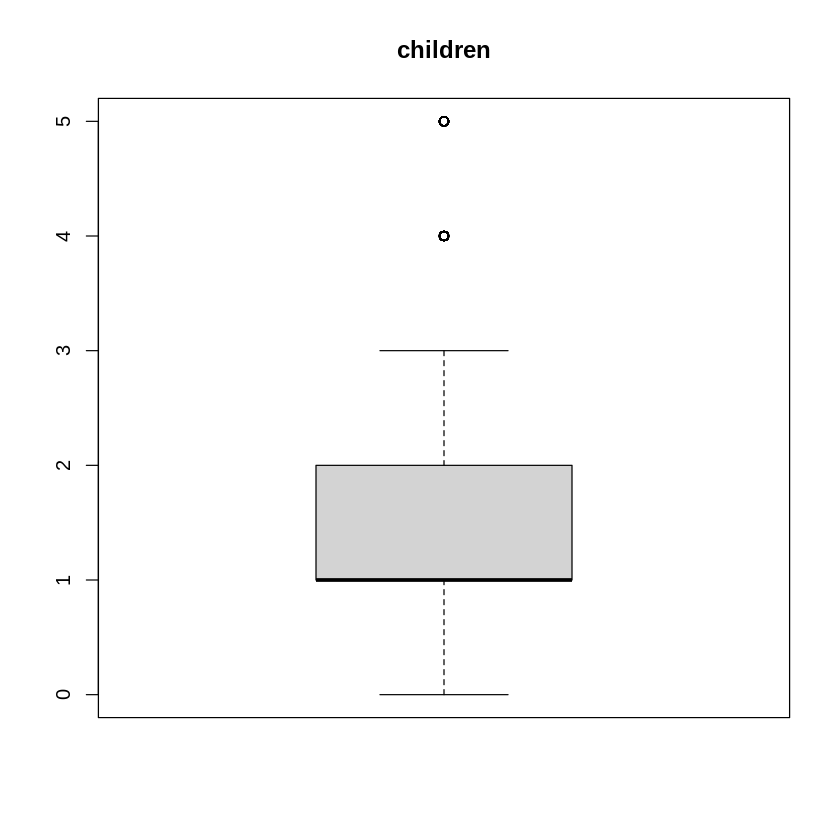

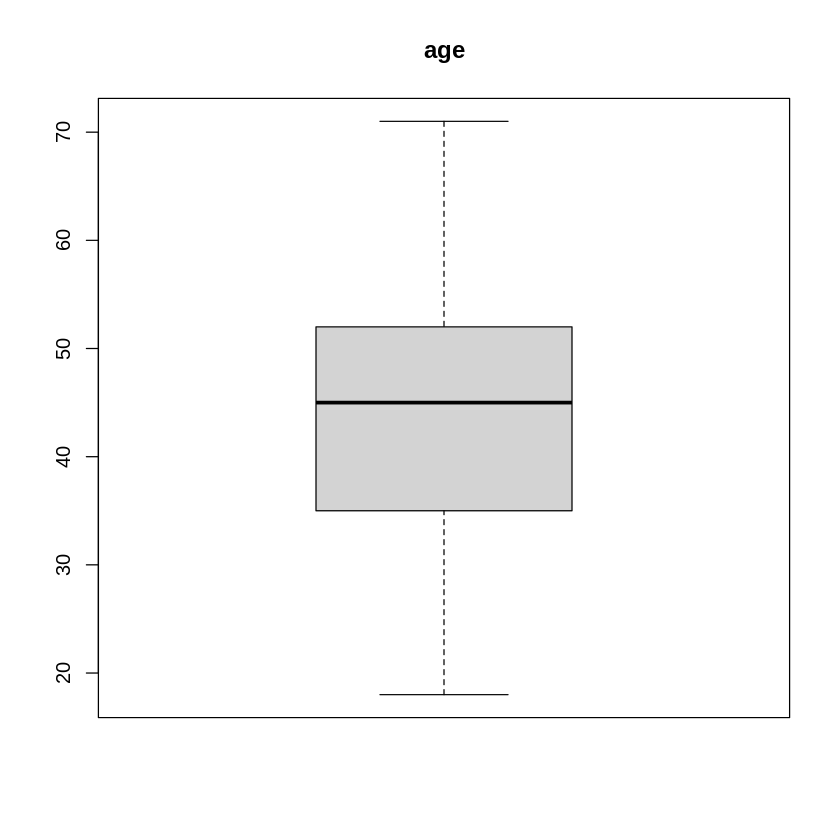

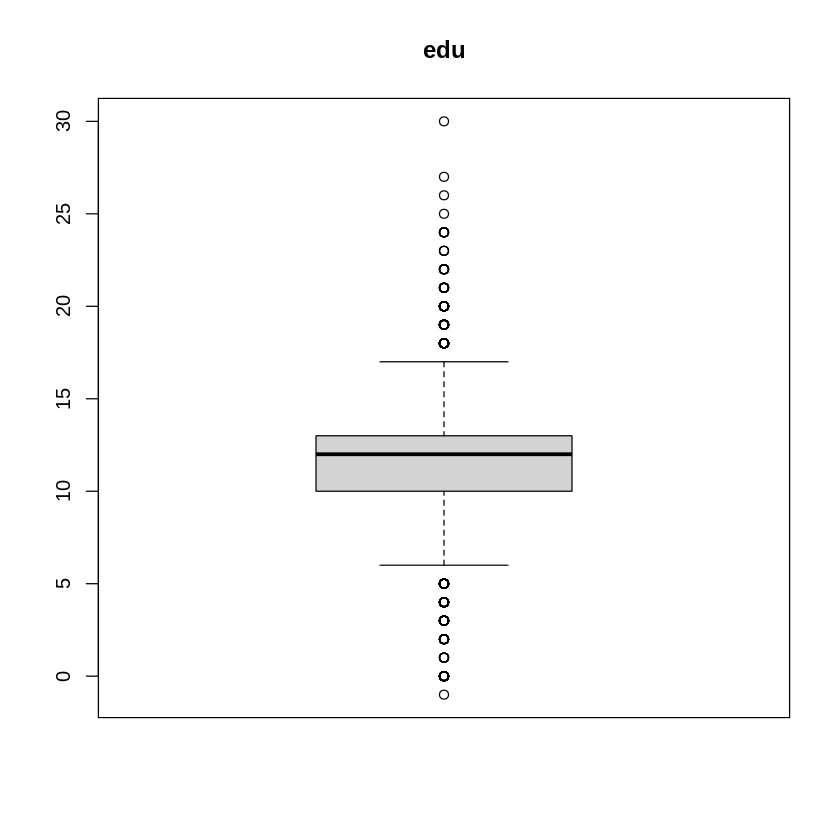

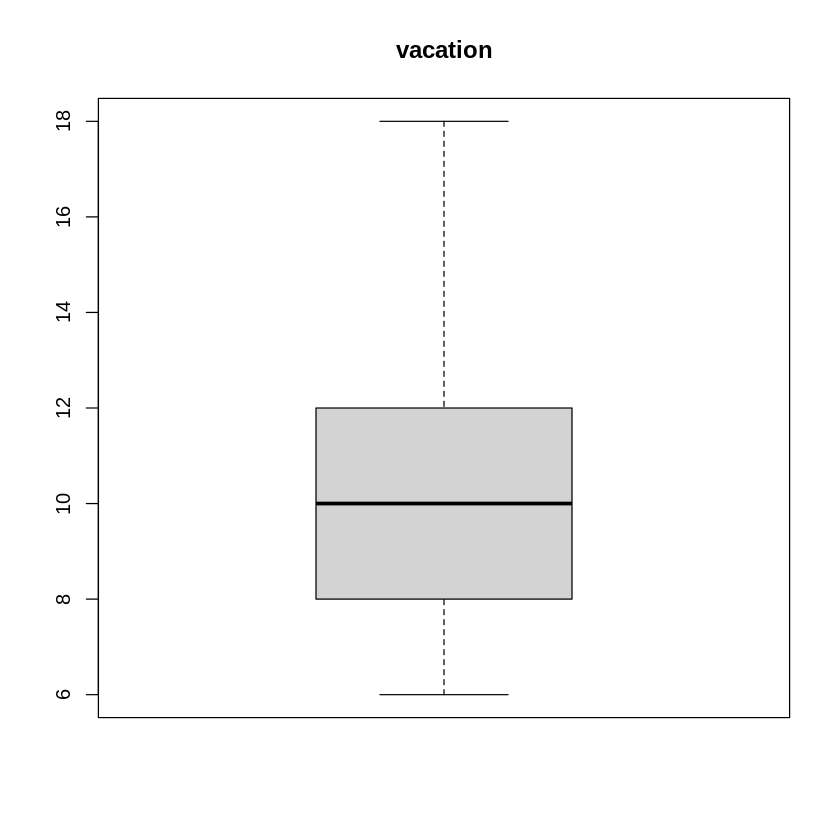

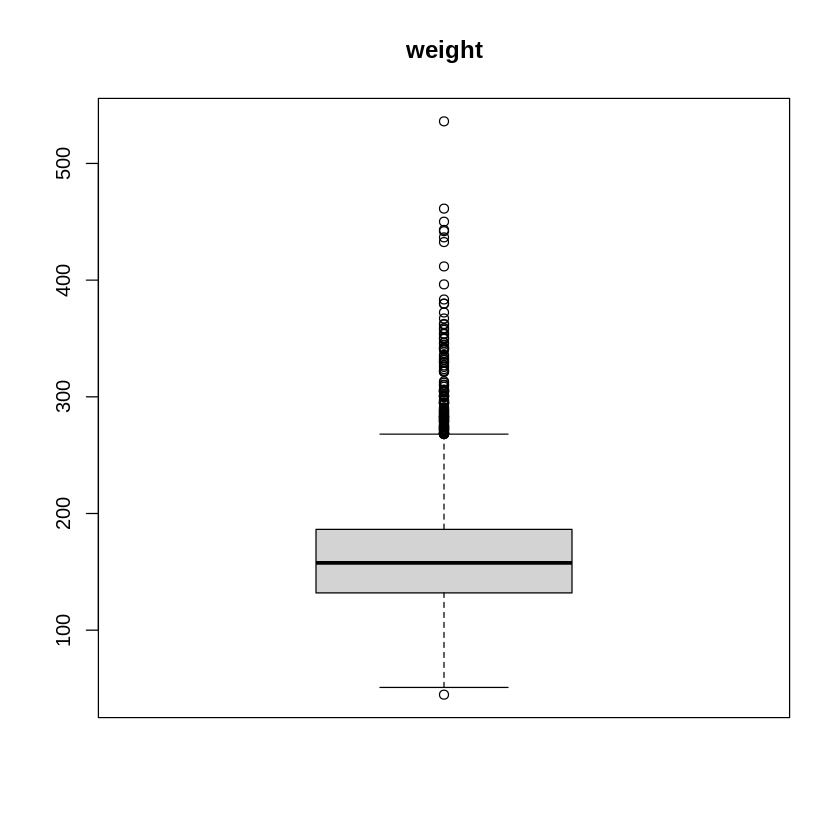

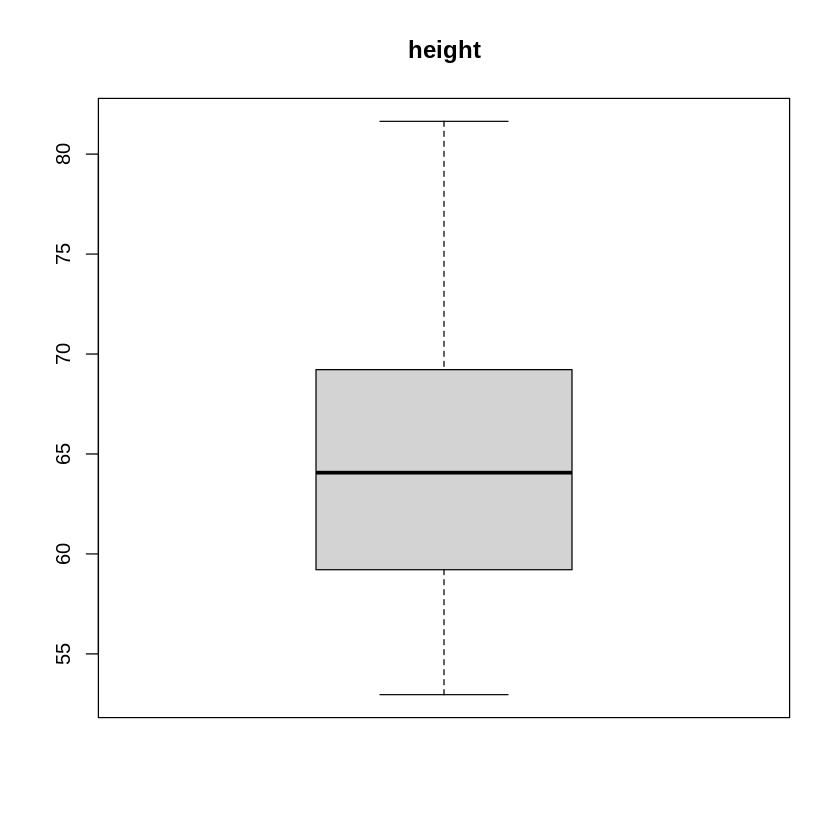

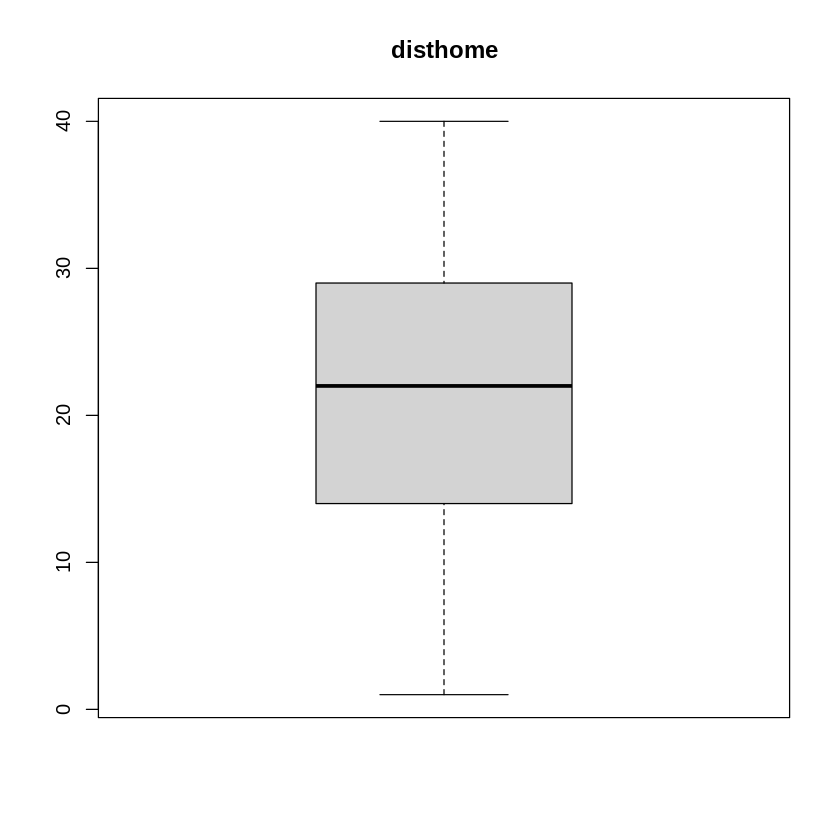

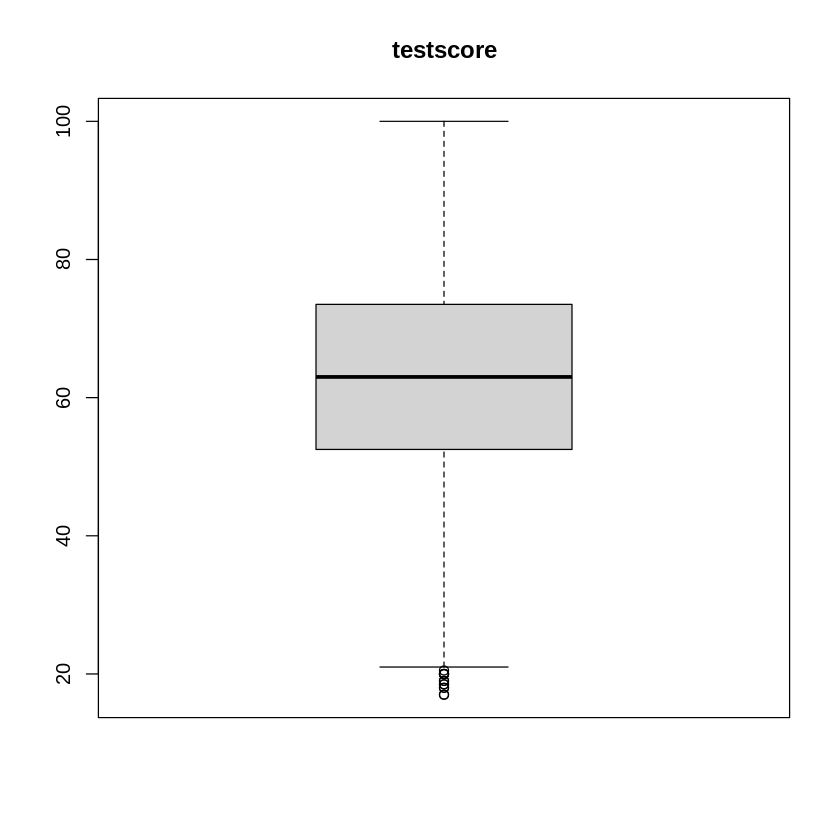

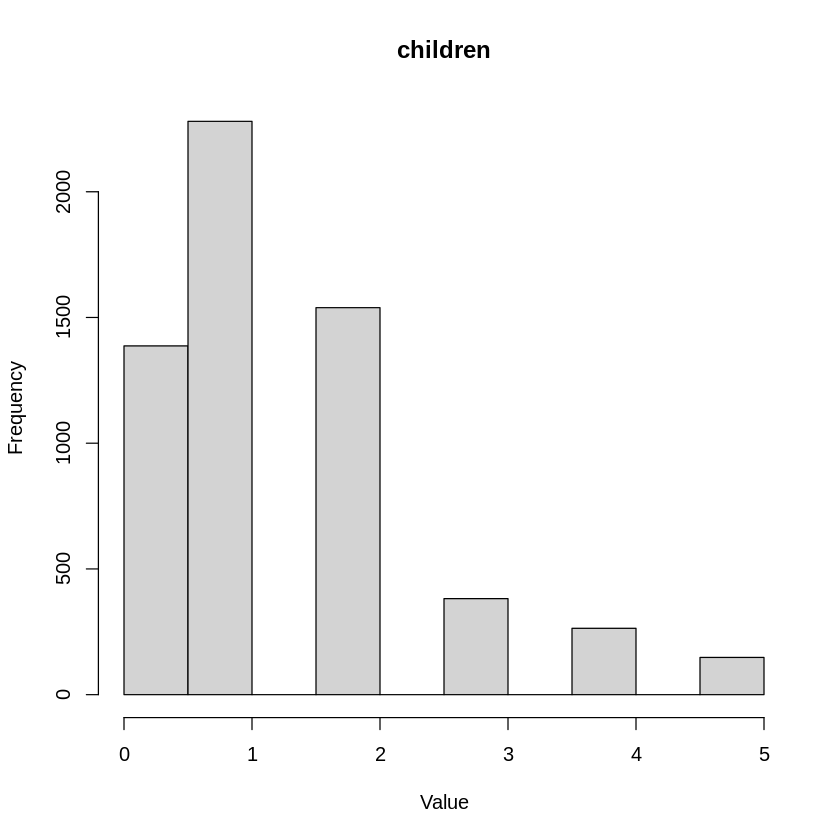

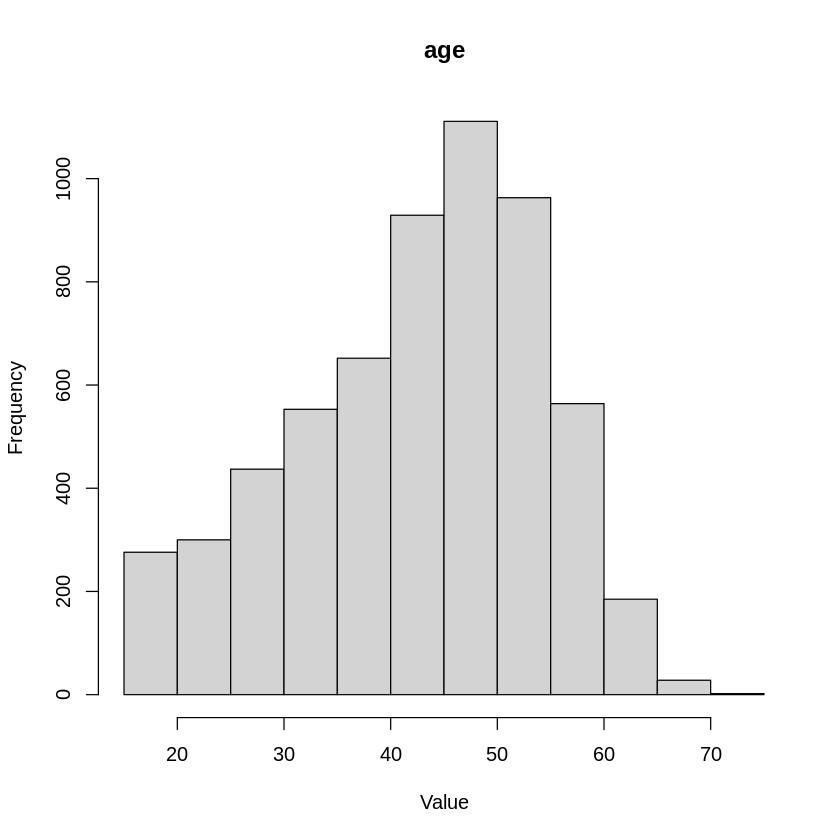

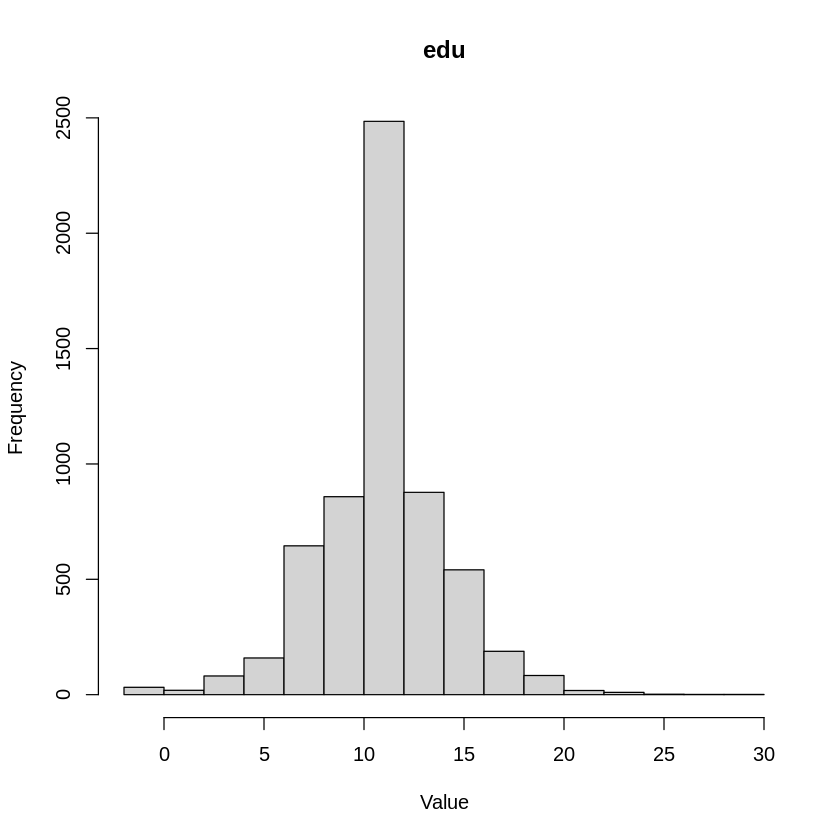

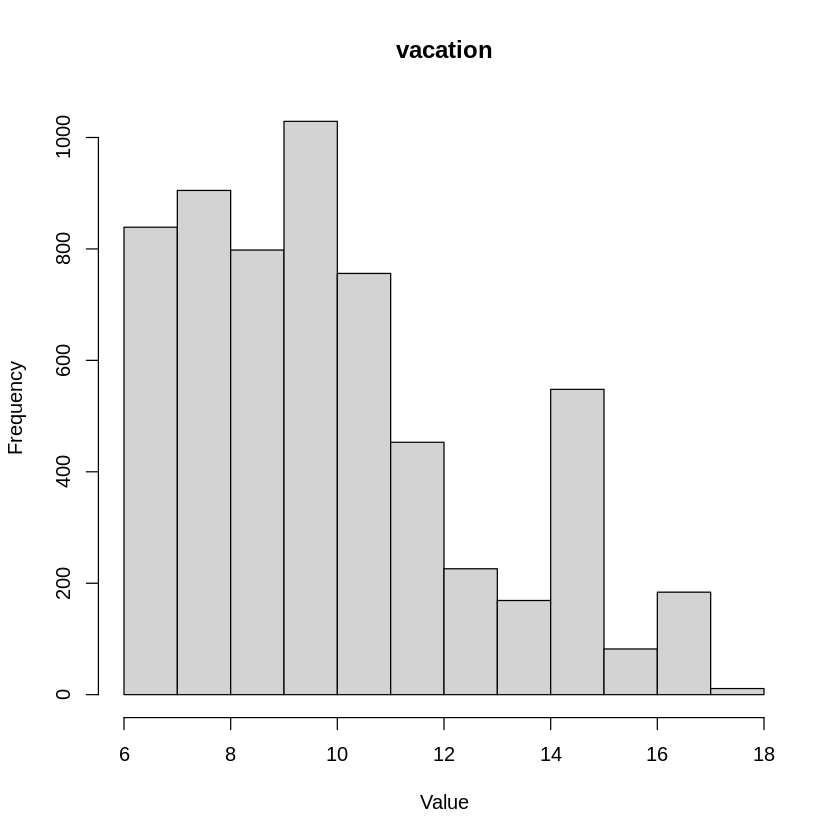

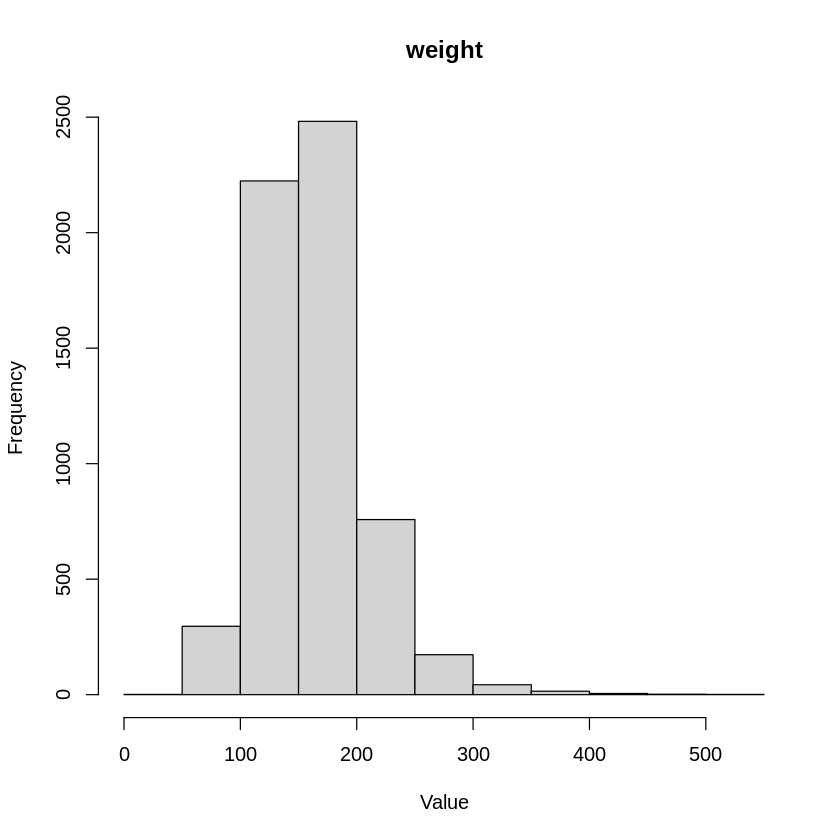

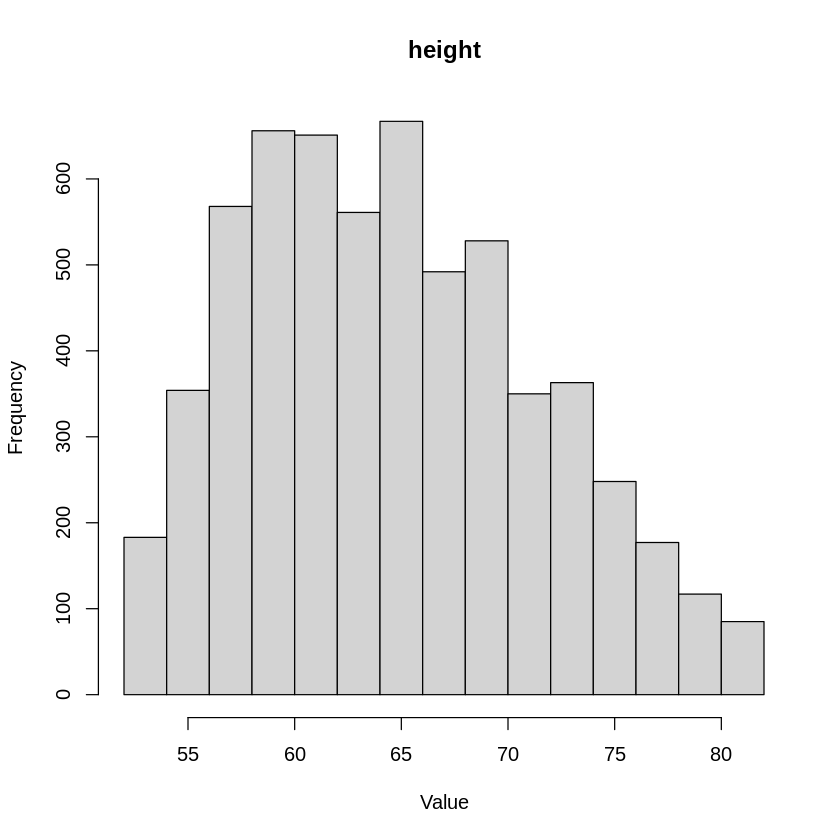

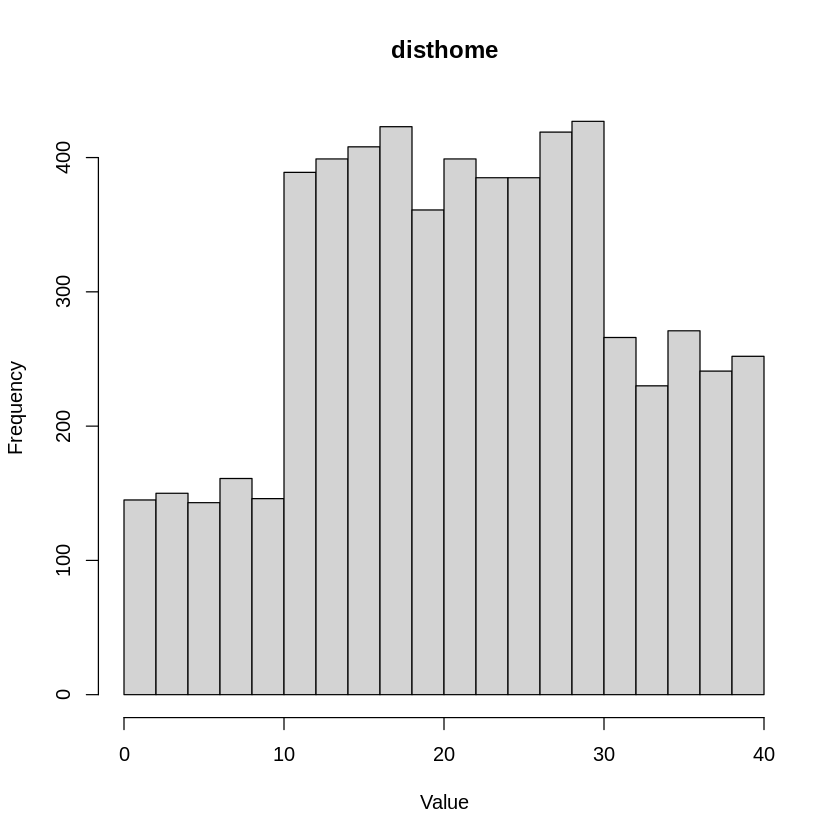

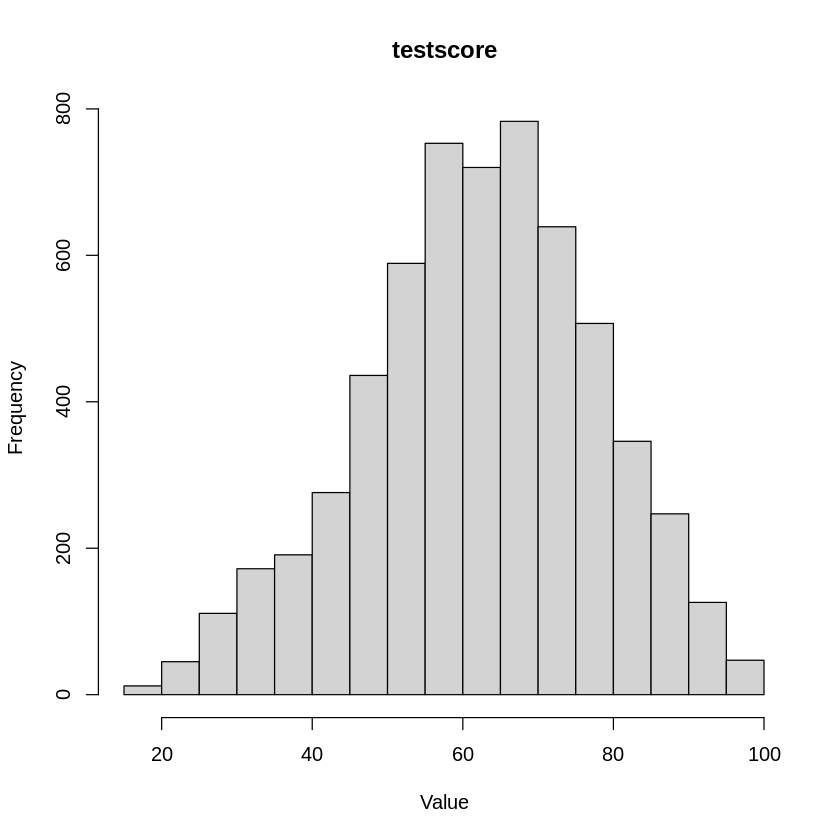

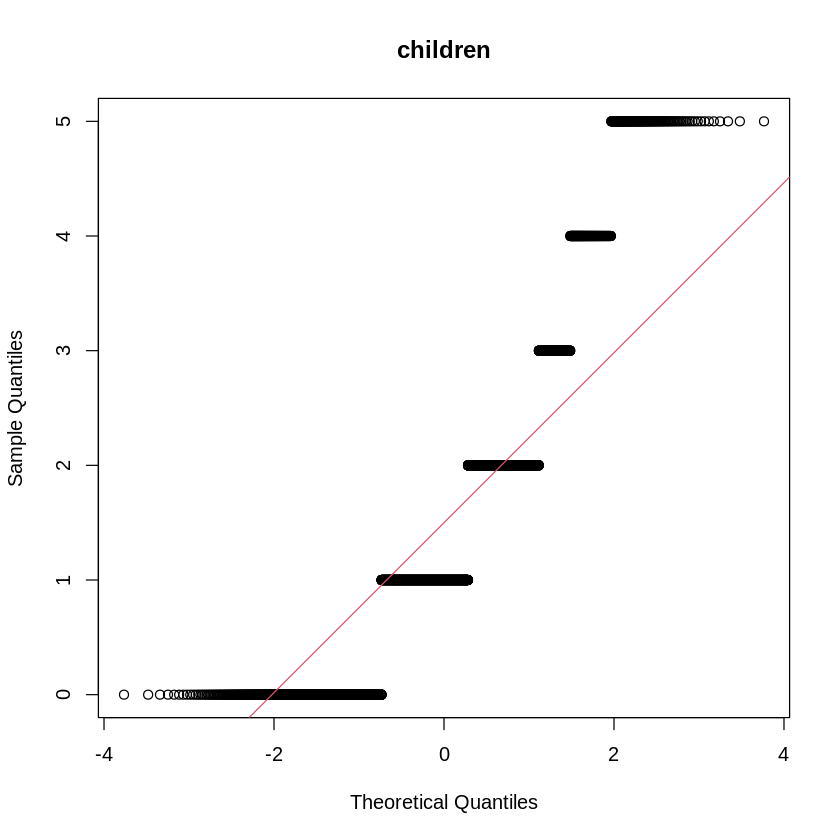

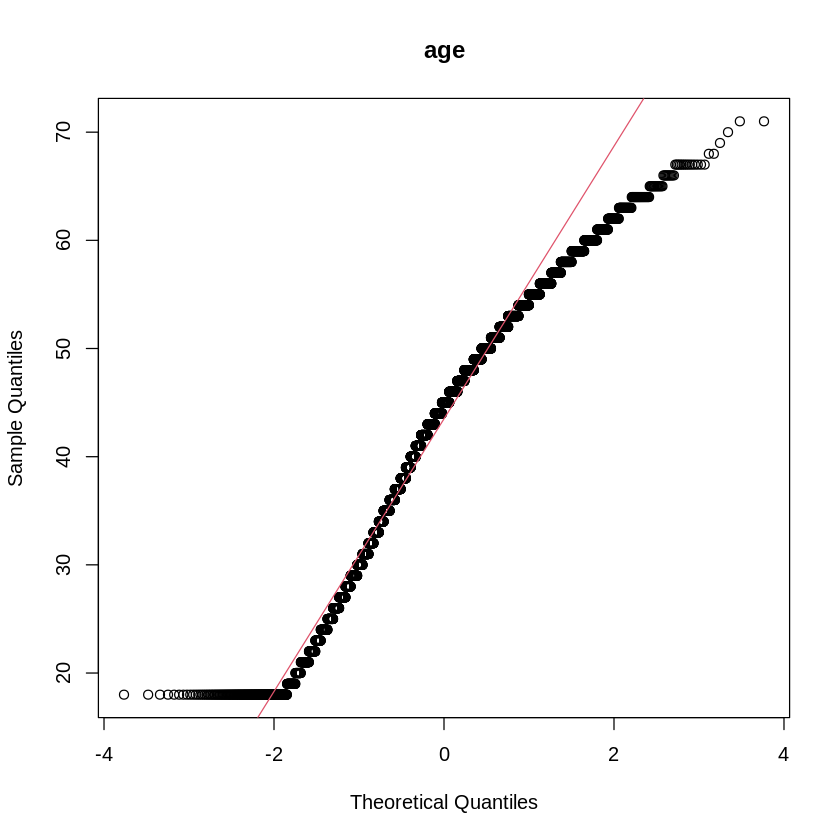

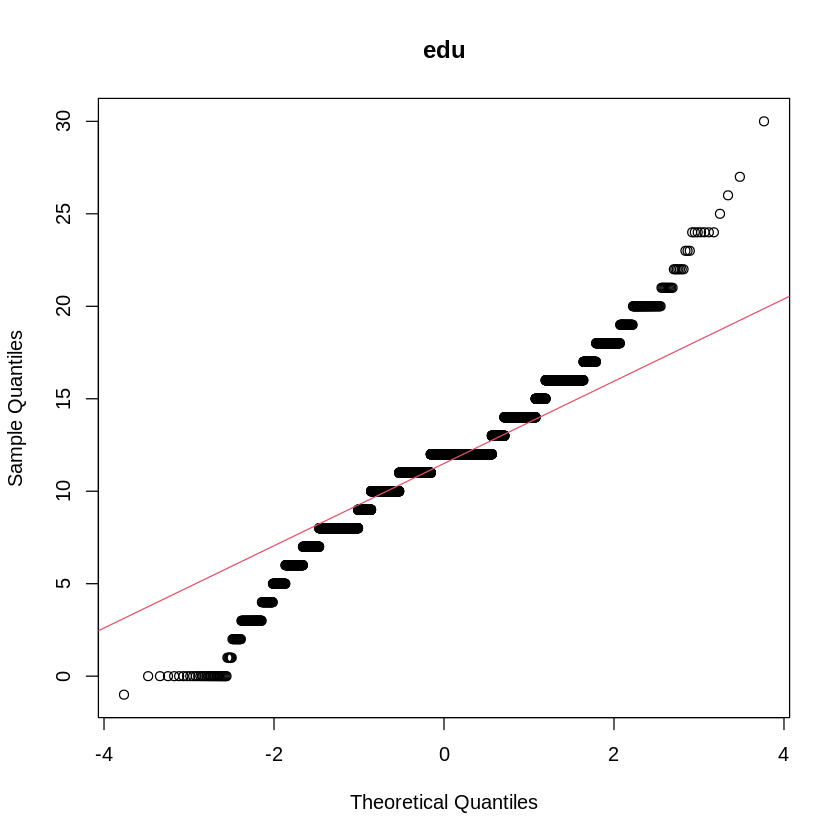

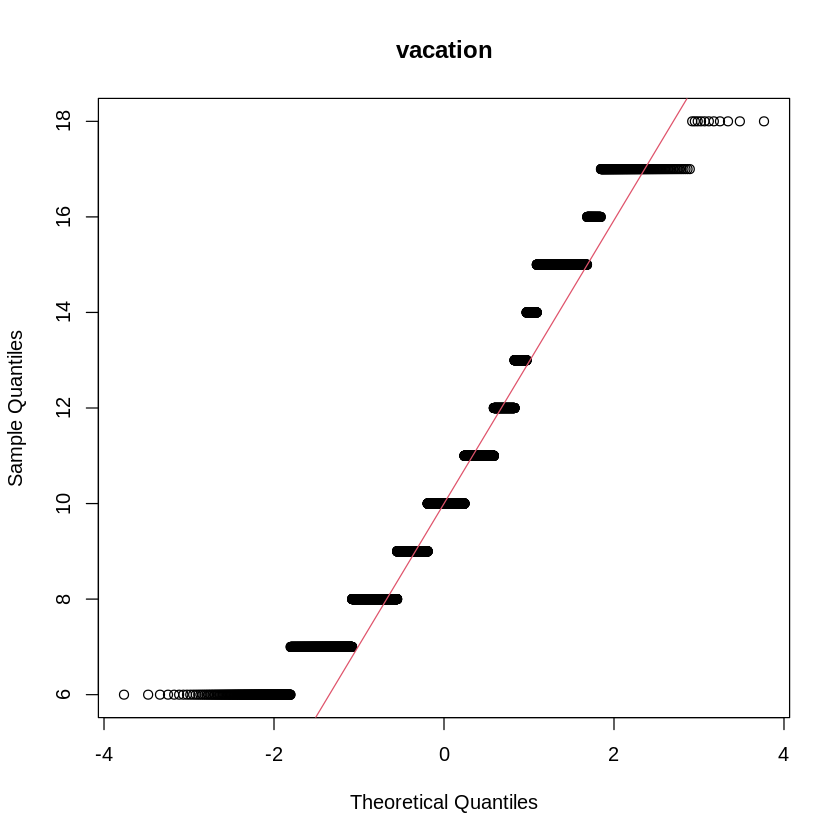

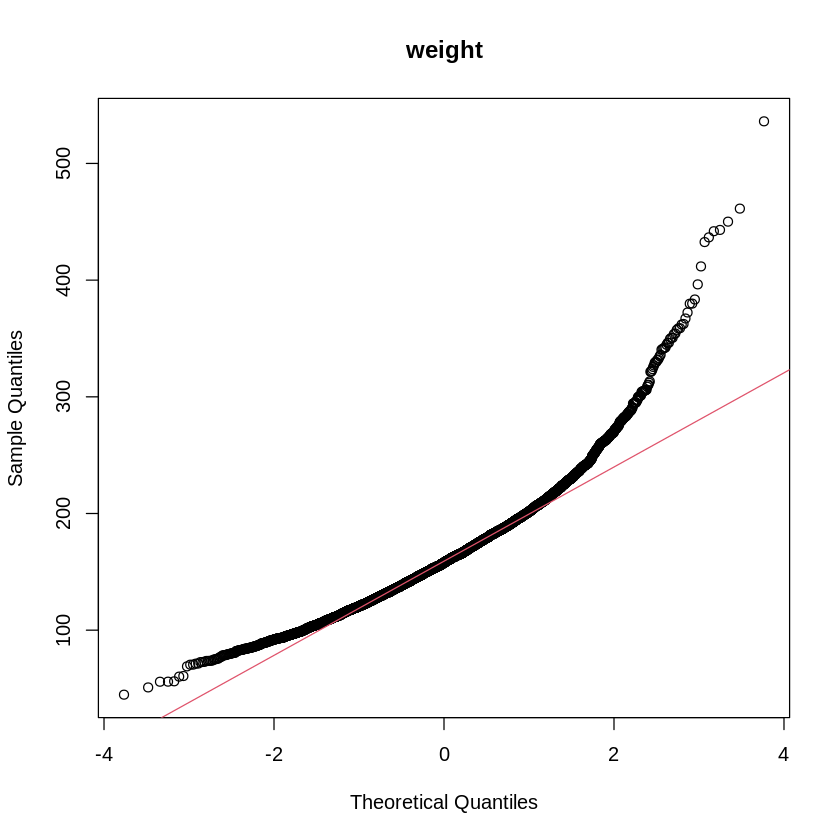

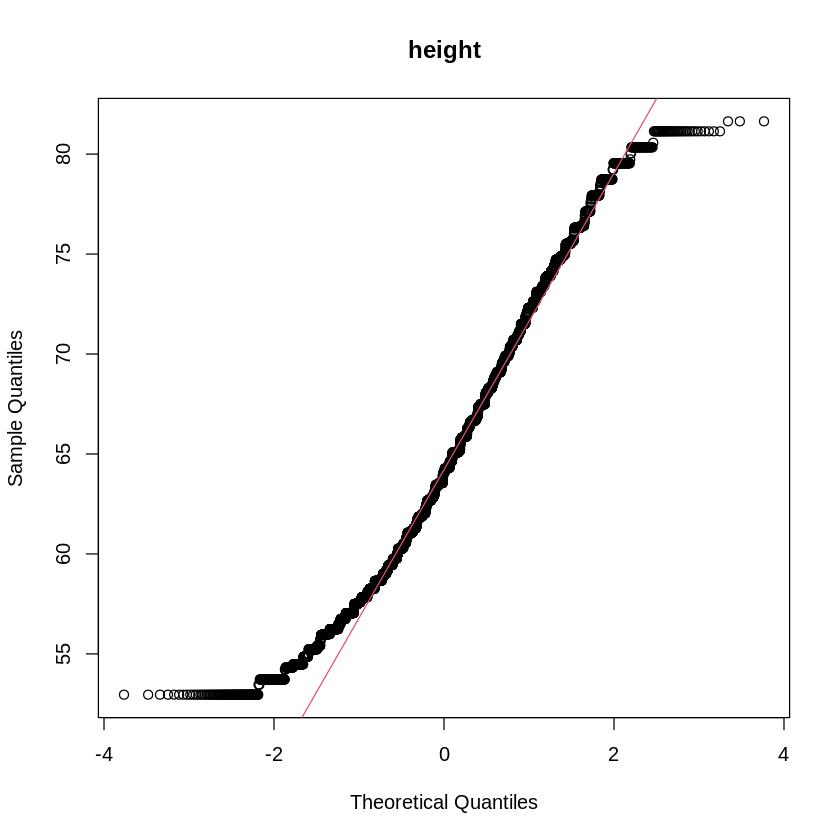

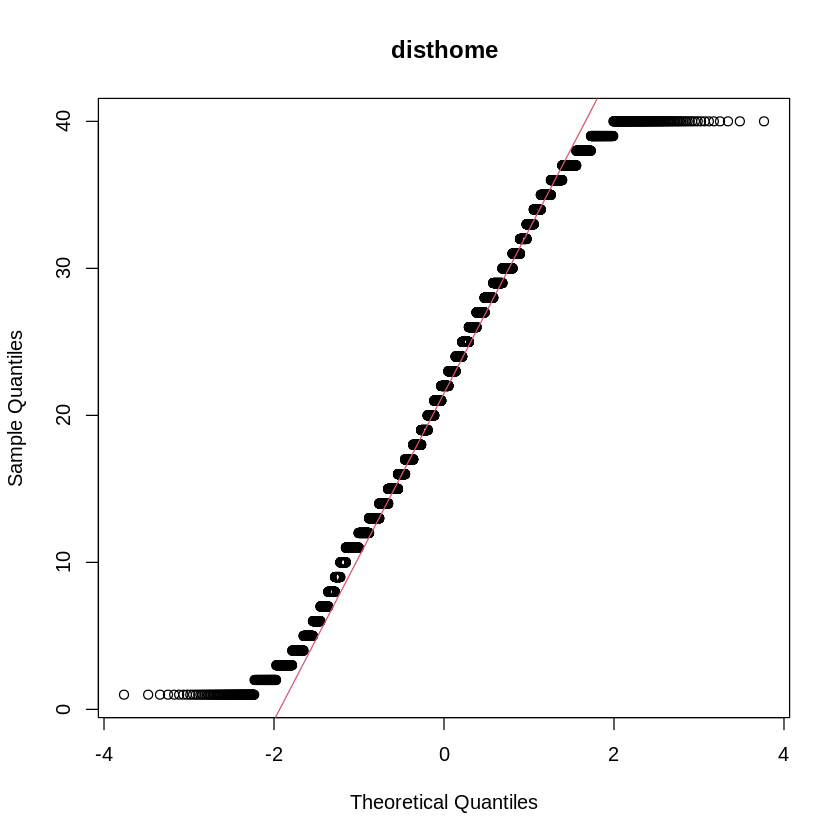

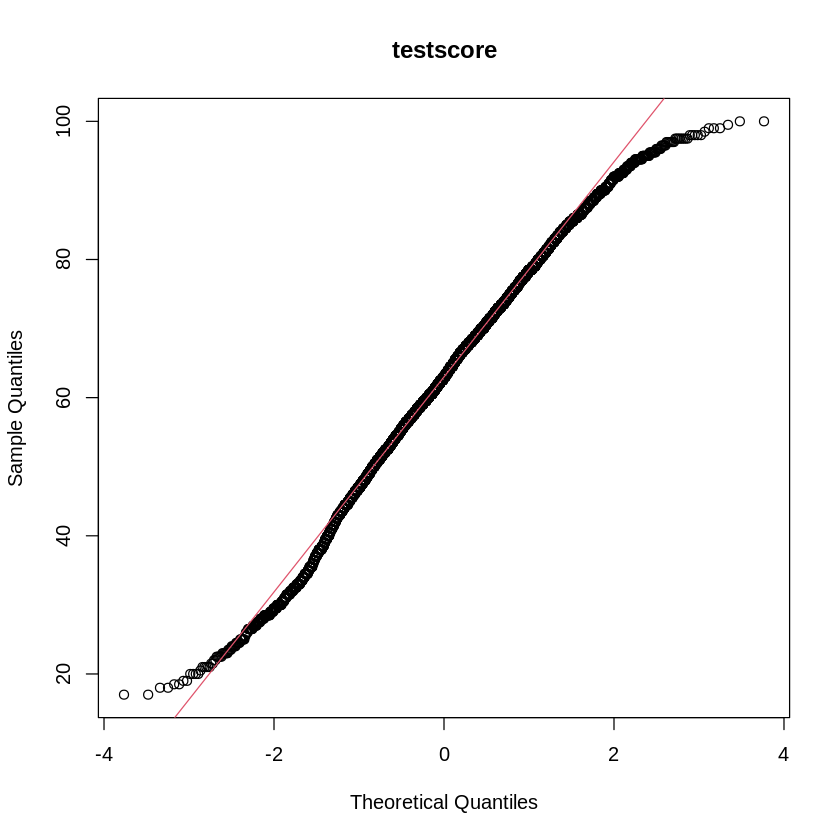

In [ ]:
# summary stats and data visualization for numeric variables
summary(data[num_var])

boxplots <- function(data, num_vars) {
  for (var in num_vars) {
    boxplot(data[[var]], main=var)
  }
}
boxplots(data, num_var)

histograms <- function(data, num_vars) {
  for (var in num_vars) {
    hist(data[[var]], main=var, xlab="Value", ylab="Frequency")
  }
}
histograms(data, num_var)

qqplots <- function(data, num_vars) {
  for (var in num_vars) {
    qqnorm(data[[var]], main=var)
    qqline(data[[var]], col=2)
  }
}
qqplots(data, num_var)

### Step 3. Assess matching balance (SMD)

Compute standardized mean difference to assess **if each covariate 𝑗 has similar means between matched treatment 𝑇 and control 𝐶 groups**

- Balanced: 𝑆𝑀𝐷𝑗 < 0.1
- Investigate: 0.1 ≤ 𝑆𝑀𝐷𝑗 ≤ 0.2
- Imbalanced: 0.2 < 𝑆𝑀𝐷𝑗

#### No Matching

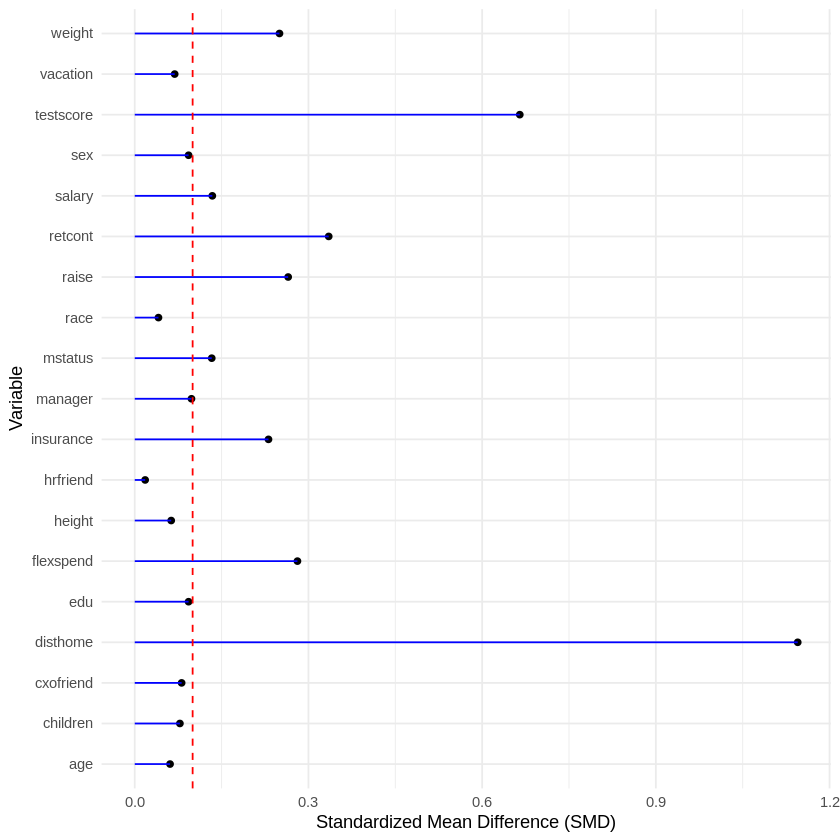

In [ ]:
# Create your data frame
df <- data.frame(
  variable = c("manager", "raise", "salary", "children", "mstatus",
               "age", "sex", "edu", "vacation", "weight",
               "height", "hrfriend", "cxofriend", "insurance", "flexspend",
               "retcont", "race", "testscore", "disthome"),
  Unmatched = c(0.098, 0.265, 0.134, 0.078, 0.133,
                0.061, 0.093, 0.093, 0.069, 0.250,
                0.063, 0.018, 0.081, 0.231, 0.281, 0.335,
                0.041, 0.665, 1.145)
)

# Create the Love plot
love_plot <- ggplot(df, aes(x = variable, y = Unmatched)) +
  geom_point() +
  geom_segment(aes(xend = variable, y = 0, yend = Unmatched), color = 'blue') +
  coord_flip() +  # Flip the axes to make the plot horizontal
  theme_minimal() +
  labs(x = "Variable", y = "Standardized Mean Difference (SMD)") +
  geom_hline(yintercept = 0.1, linetype = "dashed", color = "red") # Reference line at SMD = 0.1

# Display the plot
print(love_plot)

# Save the Love plot to a file
ggsave("love_plot.png", plot = love_plot, width = 8, height = 10, dpi = 300)


In [ ]:
## Covariates
vars <- c("manager","raise","salary","children","mstatus","age",
            "sex","edu","vacation","weight","height","hrfriend","cxofriend",
            "insurance","flexspend","retcont","race", "testscore", "disthome")

# SMD before matching
tabUnmatched <- CreateTableOne(vars = vars, strata = "training", data = data, test = FALSE)
print(tabUnmatched, smd = TRUE)

                        Stratified by training
                         0              1              SMD   
  n                        3709           2291               
  manager = Yes (%)         485 (13.1)     379 (16.5)   0.098
  raise = Yes (%)          1540 (41.5)     664 (29.0)   0.265
  salary (%)                                            0.134
     > $80k                 269 ( 7.3)     204 ( 8.9)        
     $20-$40k               743 (20.0)     471 (20.6)        
     $40-$80k               531 (14.3)     412 (18.0)        
     Under $20k            2166 (58.4)    1204 (52.6)        
  children (mean (SD))     1.35 (1.16)    1.44 (1.21)   0.078
  mstatus (%)                                           0.133
     divorced               910 (24.5)     467 (20.4)        
     married                724 (19.5)     554 (24.2)        
     single                2075 (55.9)    1270 (55.4)        
  age (mean (SD))         43.26 (11.96)  42.56 (10.80)  0.061
  sex = Male (%)       

#### 1:1 Matching

In [ ]:
# Transform categorical variables to dummy variables
covX <- dummy_cols(data[vars],
                    select_columns=c("manager","raise","salary","mstatus",
                                    "sex","hrfriend","cxofriend","insurance","flexspend","retcont","race"),
                                    remove_selected_columns=TRUE,
                                    remove_first_dummy=TRUE)

# Perform 1:1 Matching
listMatch <- Match(Tr = (data$training == 1),
                X = covX,
                M = 1,
                caliper = 1.7,
                replace = FALSE,
                ties = TRUE,
                version = "fast")

# Extract matched data
tpdMatched <- data[unlist(listMatch[c("index.treated","index.control")]), ]
tabMatched <- CreateTableOne(vars = vars, strata = "training", data = tpdMatched, test = FALSE)

print(tabMatched, smd = TRUE)

                       Stratified by training
                        0              1              SMD   
  n                        638            638               
  manager = Yes (%)         76 (11.9)      76 (11.9)  <0.001
  raise = Yes (%)          187 (29.3)     187 (29.3)  <0.001
  salary (%)                                          <0.001
     > $80k                 36 ( 5.6)      36 ( 5.6)        
     $20-$40k               87 (13.6)      87 (13.6)        
     $40-$80k               83 (13.0)      83 (13.0)        
     Under $20k            432 (67.7)     432 (67.7)        
  children (mean (SD))    1.21 (1.03)    1.23 (1.04)   0.021
  mstatus (%)                                         <0.001
     divorced              124 (19.4)     124 (19.4)        
     married                93 (14.6)      93 (14.6)        
     single                421 (66.0)     421 (66.0)        
  age (mean (SD))        45.13 (9.95)   44.55 (9.75)   0.060
  sex = Male (%)           371 (58.2)  

#### PSM Matching

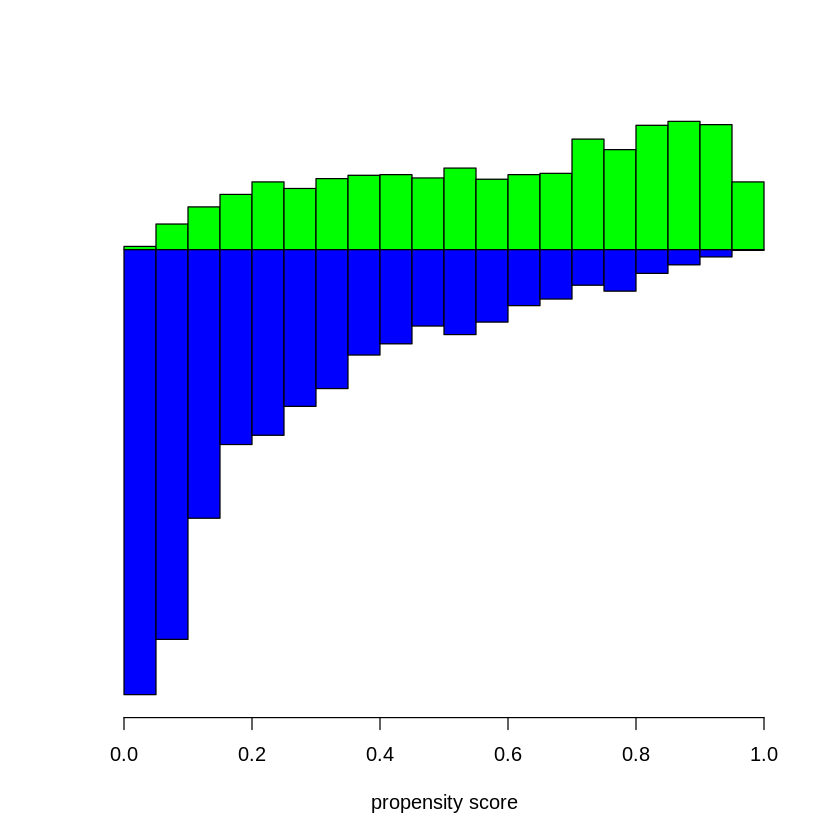

In [ ]:
# Fit propensity score model
psModel <- glm(formula = (training == 1) ~ manager+raise+salary+children
                                                +mstatus+age+sex+edu+vacation
                                                +weight+height+hrfriend+cxofriend
                                                +insurance+flexspend+retcont+race+testscore+disthome,
                family = binomial(link = "logit"),
                data = data)

# Predicted probability of being assigned to Train
data$pTrain <- predict(psModel, type = "response")

## Predicted probability of being assigned to no Train
data$pNoTrain <- 1 - data$pTrain

#create plot to check overlap
hTrain = hist(data$pTrain[data$training== 1], plot=FALSE,breaks=20)
hNoTrain = hist(data$pTrain[data$training== 0], plot=FALSE,breaks=20)
hNoTrain$counts = - hNoTrain$counts
hmax = max(hTrain$counts)
hmin = min(hNoTrain$counts)
plotx = c(hTrain$breaks, hNoTrain$breaks)
xmax = max(plotx)
xmin = min(plotx)
plot(hTrain, ylim=c(hmin, hmax), col="Green", xlim=c(xmin, xmax), xlab='propensity score',main="",yaxt='n',ylab='')
lines(hNoTrain, col="blue")

set.seed(314159) ## Set random number seed

In [ ]:
## Perform 1:1 Propensity Score Matching

listPSMatch <- Match(Tr = (data$training == 1),
                    X = log(data$pTrain / data$pNoTrain),
                    M = 1, caliper = 0.6,
                    replace = FALSE,
                    ties = TRUE,
                    version = "fast")

## Extract matched data
tpdPSMatched <- data[unlist(listPSMatch[c("index.treated","index.control")]), ]

## Construct a table
tabPSMatched <- CreateTableOne(vars = vars, strata = "training", data = tpdPSMatched, test = FALSE)

## Show table with SMD
print(tabPSMatched, smd = TRUE)

                        Stratified by training
                         0              1              SMD   
  n                        1566           1566               
  manager = Yes (%)         221 (14.1)     233 (14.9)   0.022
  raise = Yes (%)           537 (34.3)     506 (32.3)   0.042
  salary (%)                                            0.025
     > $80k                 134 ( 8.6)     132 ( 8.4)        
     $20-$40k               336 (21.5)     322 (20.6)        
     $40-$80k               240 (15.3)     249 (15.9)        
     Under $20k             856 (54.7)     863 (55.1)        
  children (mean (SD))     1.40 (1.19)    1.43 (1.21)   0.028
  mstatus (%)                                           0.030
     divorced               350 (22.3)     341 (21.8)        
     married                346 (22.1)     365 (23.3)        
     single                 870 (55.6)     860 (54.9)        
  age (mean (SD))         42.68 (11.70)  42.58 (10.99)  0.008
  sex = Male (%)       

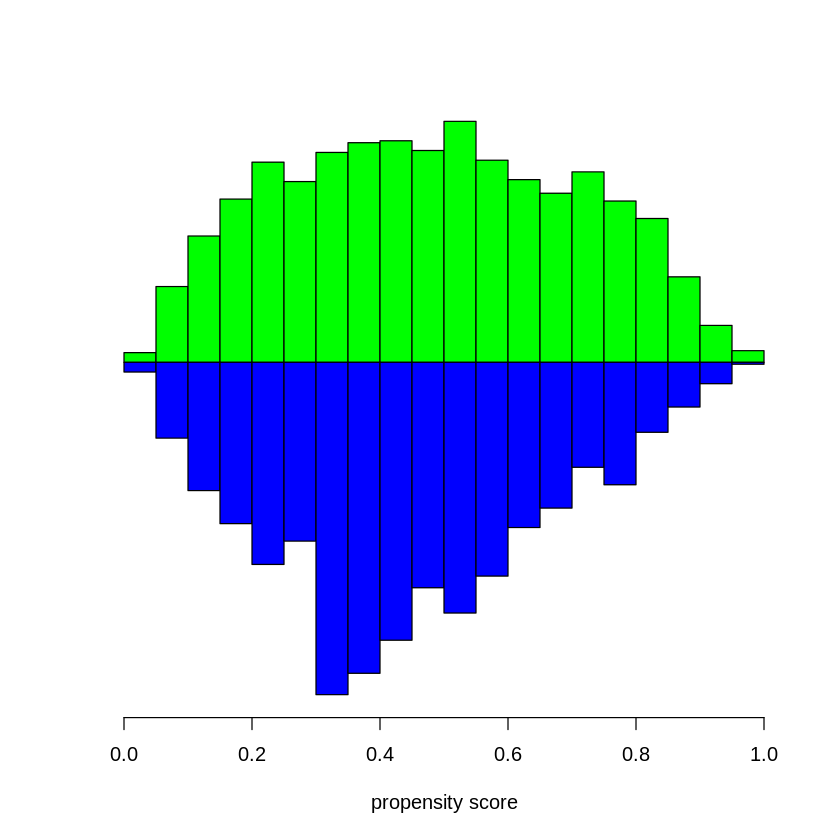

In [ ]:
#create plot to check overlap
hTrain = hist(tpdPSMatched$pTrain[tpdPSMatched$training==1], plot=FALSE,breaks=20)
hNoTrain = hist(tpdPSMatched$pTrain[tpdPSMatched$training==0], plot=FALSE,breaks=20)
hNoTrain$counts = - hNoTrain$counts
hmax = max(hTrain$counts)
hmin = min(hNoTrain$counts)
plotx = c(hTrain$breaks, hNoTrain$breaks)
xmax = max(plotx)
xmin = min(plotx)
plot(hTrain, ylim=c(hmin, hmax), col="Green", xlim=c(xmin, xmax), xlab='propensity score',main="",yaxt='n',ylab='')
lines(hNoTrain, col="blue")

#### IPTW

In [ ]:
## Weighted analysis

## Predicted probability of being assigned to the
## treatment actually assigned (either Train or No Train)
data$pAssign <- NA
data$pAssign[data$training == 1] <- data$pTrain[data$training == 1]
data$pAssign[data$training == 0] <- data$pNoTrain[data$training == 0]

## Weight
data$mw <- 1 / data$pAssign

## Weighted data
tpdSvy <- svydesign(ids = ~ 1, data = data, weights = ~ mw)

## Construct a Table 1
tabWeighted <- svyCreateTableOne(vars = vars, strata = "training", data = tpdSvy, test = FALSE)

## Show table with SMD
print(tabWeighted, smd = TRUE)

                        Stratified by training
                         0               1               SMD   
  n                       5898.3          5555.1               
  manager = Yes (%)        833.0 (14.1)    779.2 (14.0)   0.003
  raise = Yes (%)         2150.4 (36.5)   1995.7 (35.9)   0.011
  salary (%)                                              0.016
     > $80k                438.2 ( 7.4)    433.7 ( 7.8)        
     $20-$40k             1218.8 (20.7)   1138.7 (20.5)        
     $40-$80k              924.7 (15.7)    855.9 (15.4)        
     Under $20k           3316.7 (56.2)   3126.9 (56.3)        
  children (mean (SD))      1.37 (1.18)     1.39 (1.19)   0.016
  mstatus (%)                                             0.032
     divorced             1322.5 (22.4)   1284.0 (23.1)        
     married              1255.0 (21.3)   1230.3 (22.1)        
     single               3320.8 (56.3)   3040.8 (54.7)        
  age (mean (SD))          42.91 (11.85)   42.86 (11.16) 

### Q1. What is the impact of the Career 2030 program on employee promotions?

In [ ]:
## Unmatched model
glmUnmatched <- glm(formula = promoted ~ training,
                    family = binomial(link = "logit"),
                    data = data)

## Matched model (caliper= )
glmMatched <- glm(formula = promoted ~ training,
                  family = binomial(link = "logit"),
                  data = tpdMatched)

## Propensity Score Matched model (caliper= )
glmPSMatched <- glm(formula = promoted ~ training,
                    family = binomial(link = "logit"),
                    data = tpdPSMatched)

## Show results together
resTogether <- list(Unmatched = ShowRegTable(glmUnmatched, printToggle = FALSE),
            Matched = ShowRegTable(glmMatched, printToggle = FALSE),
            PSMatched = ShowRegTable(glmPSMatched, printToggle = FALSE))

print(resTogether, quote = FALSE)

$Unmatched
            exp(coef) [confint] p     
(Intercept) 1.72 [1.61, 1.84]   <0.001
training    1.24 [1.11, 1.39]   <0.001

$Matched
            exp(coef) [confint] p     
(Intercept) 1.90 [1.62, 2.24]   <0.001
training    1.51 [1.19, 1.92]    0.001

$PSMatched
            exp(coef) [confint] p     
(Intercept) 1.13 [1.02, 1.25]    0.015
training    2.43 [2.09, 2.82]   <0.001



### Q2. Are there any hidden bias?

In [2]:
# Extract row numbers of matched pairs (PSM Matching)
id_treated <- listPSMatch$index.treated
id_control <- listPSMatch$index.control

# Create a new dataset to store matched pairs with propensity scores
matched_data <- data.frame(
  id_treated = id_treated,
  pTrain_treated = data$pTrain[id_treated],
  id_control = id_control,
  pTrain_control = data$pTrain[id_control]
)
matched_data

ERROR: Error in eval(expr, envir, enclos): object 'listPSMatch' not found


In [3]:
matched_data

ERROR: Error in eval(expr, envir, enclos): object 'matched_data' not found


In [ ]:
# Calculate odds ratio for each matched pair
matched_data$odds_ratio <- with(matched_data, (pTrain_treated / (1 - pTrain_treated)) / (pTrain_control / (1 - pTrain_control)))

# Define bounds on the odds ratio
gamma_values <- c(1.1, 2, 3)
sensitivity_results <- numeric(length(gamma_values))  # Initialize vector to store sensitivity results

for (i in seq_along(gamma_values)) {
    # Compute within bounds for the gamma value
    matched_data$within_bounds <- with(matched_data, odds_ratio >= (1 / gamma_values[i]) & odds_ratio <= gamma_values[i])

    sensitivity_results[i] <- sum(matched_data$within_bounds) / nrow(matched_data)
}

# Print sensitivity results
sensitivity_results

### Q3. Two-Step Regression

In [4]:
install.packages("ivreg")
library(ivreg)

# Instrumental Variable Analysis: disthome
ivmodel <- ivreg(promoted ~ training + raise + salary + children + mstatus + age +
                sex + edu + vacation + weight + height + hrfriend + cxofriend +
                insurance + flexspend + retcont + race + testscore |

                training + raise + salary + children + mstatus + age +
                sex + edu + vacation + weight + height + hrfriend + cxofriend +
                insurance + flexspend + retcont + race + testscore + disthome, data = tpdPSMatched)
summary(ivmodel)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘car’, ‘Formula’, ‘lmtest’




ERROR: Error in eval(mf, parent.frame()): object 'tpdPSMatched' not found


In [ ]:
ivmodel_interaction <- ivreg(promoted ~ training * (raise + salary + children + mstatus + age +
                                                     sex + edu + vacation + weight + height + hrfriend +
                                                     cxofriend + insurance + flexspend + retcont + race +
                                                     testscore) |

                                         training + raise + salary + children + mstatus + age +
                                         sex + edu + vacation + weight + height + hrfriend + cxofriend +
                                         insurance + flexspend + retcont + race + testscore + disthome,
                                         data = tpdPSMatched)
summary(ivmodel_interaction)